In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [37]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 13))

In [38]:
rand_sub_bval_indice_100206

array([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 26

In [ ]:
# 13g_03 random
# [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
#         13,  14,  15,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
#         58,  59,  60,  61,  62,  63,  80,  81,  82,  83,  84,  85,  86,
#         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
#        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
#        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
#        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
#        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
#        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
#        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
#        178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
#        208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
#        221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
#        234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
#        247, 248, 249, 250, 251, 252, 253, 254, 255, 272, 273, 274, 275,
#        276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287]

In [39]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [40]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [41]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [42]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [43]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

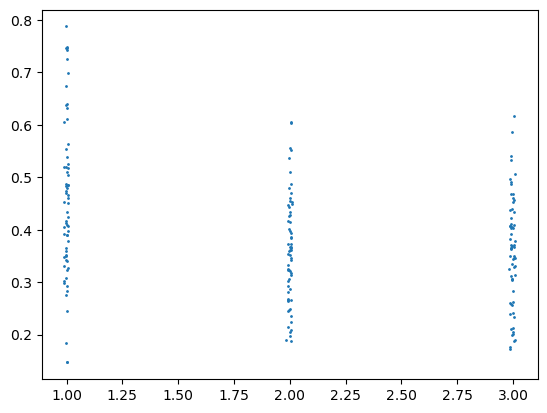

In [44]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [14]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [45]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [46]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(194, 3)


In [47]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [48]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [34]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.12it/s]


Loss: 507.6341899917461
Average Loss: 0.06946280651228053
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.97it/s]


Loss: 424.3705542059615
Average Loss: 0.058069315025446294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.97it/s]


Loss: 422.01980361621827
Average Loss: 0.05774764690971788
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.24it/s]


Loss: 419.94812616542913
Average Loss: 0.05746416614195801
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.59it/s]


Loss: 419.6787501964718
Average Loss: 0.057427305719276386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.31it/s]


Loss: 420.0997072062455
Average Loss: 0.05748490793736255
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.60it/s]


Loss: 418.7298775278032
Average Loss: 0.05729746545262769
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.68it/s]


Loss: 418.410248817876
Average Loss: 0.057253728628609196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.79it/s]


Loss: 417.6720197699033
Average Loss: 0.05715271206484719
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.22it/s]


Loss: 417.74702308746055
Average Loss: 0.05716297524458957
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  2%|██▊                                                                                                                                                           | 128/7308 [00:02<00:48, 147.25it/s]

X_batch: 
torch.Size([128, 194])
tensor([[0.4603, 0.2327, 0.1015,  ..., 0.4017, 0.1639, 0.1555],
        [0.4759, 0.3279, 0.2426,  ..., 0.3864, 0.2600, 0.4039],
        [0.6547, 0.4595, 0.1026,  ..., 0.5166, 0.4495, 0.6119],
        ...,
        [0.5144, 0.4079, 0.1182,  ..., 0.3640, 0.4324, 0.2529],
        [0.5042, 0.3046, 0.1536,  ..., 0.4959, 0.2658, 0.2059],
        [0.5045, 0.3315, 0.1844,  ..., 0.5694, 0.3996, 0.1696]])
X_pred: 
torch.Size([128, 194])
tensor([[0.3889, 0.2077, 0.1485,  ..., 0.3778, 0.2066, 0.1407],
        [0.4351, 0.2578, 0.1796,  ..., 0.4176, 0.2639, 0.1850],
        [0.5183, 0.3430, 0.2388,  ..., 0.4995, 0.3531, 0.2592],
        ...,
        [0.4861, 0.3166, 0.2258,  ..., 0.4653, 0.3272, 0.2399],
        [0.4795, 0.2517, 0.1432,  ..., 0.4709, 0.2549, 0.1446],
        [0.5126, 0.2965, 0.1884,  ..., 0.4991, 0.3020, 0.1893]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.17it/s]


Loss: 417.4136458616704
Average Loss: 0.057117357123928625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.09it/s]


Loss: 417.65665813628584
Average Loss: 0.057150610035069216
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.83it/s]


Loss: 417.4151803017594
Average Loss: 0.05711756709110008
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.04it/s]


Loss: 417.0082799925003
Average Loss: 0.057061888340517286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.49it/s]


Loss: 417.2523585478775
Average Loss: 0.05709528715761871
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.08it/s]


Loss: 416.5582502973266
Average Loss: 0.057000307922458485
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.79it/s]


Loss: 416.6573952627368
Average Loss: 0.057013874557024745
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.59it/s]


Loss: 416.0110672551673
Average Loss: 0.05692543339561676
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.79it/s]


Loss: 416.27881687204354
Average Loss: 0.05696207127422599
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.95it/s]


Loss: 415.4167466671206
Average Loss: 0.05684410873934327
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.45it/s]


Loss: 415.42250815662555
Average Loss: 0.05684489712050158
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.53it/s]


Loss: 415.4338373262435
Average Loss: 0.056846447362649634
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.20it/s]


Loss: 415.1042975373566
Average Loss: 0.05680135434282384
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.55it/s]


Loss: 415.15549223008566
Average Loss: 0.05680835963739541
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.65it/s]


Loss: 415.1490870954003
Average Loss: 0.056807483182183954
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.39it/s]


Loss: 414.57667952030897
Average Loss: 0.05672915702248344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.73it/s]


Loss: 414.69450342375785
Average Loss: 0.05674527961463572
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.59it/s]


Loss: 414.8520167125389
Average Loss: 0.05676683315716186
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.11it/s]


Loss: 414.0049508898519
Average Loss: 0.05665092376708428
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.37it/s]


Loss: 414.41105912066996
Average Loss: 0.05670649413254925
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.97it/s]


Loss: 414.1839938007761
Average Loss: 0.05667542334438644
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.98it/s]


Loss: 413.8594111278653
Average Loss: 0.05663100863818628
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.24it/s]


Loss: 414.03971172706224
Average Loss: 0.05665568031295323
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.67it/s]


Loss: 413.88733123615384
Average Loss: 0.05663482912372111
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.00it/s]


Loss: 413.29965067259036
Average Loss: 0.05655441306412019
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.57it/s]


Loss: 413.8433946457226
Average Loss: 0.056628817001330406
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.99it/s]


Loss: 413.4783922522329
Average Loss: 0.056578871408351515
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.66it/s]


Loss: 413.7248366109561
Average Loss: 0.056612593953332804
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.29it/s]


Loss: 413.12016538949683
Average Loss: 0.056529852954227806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.52it/s]


Loss: 413.12682516290806
Average Loss: 0.05653076425327149
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.23it/s]


Loss: 412.80135380174033
Average Loss: 0.05648622794221953
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.58it/s]


Loss: 413.6503379752394
Average Loss: 0.05660239983240824
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.06it/s]


Loss: 413.110788108781
Average Loss: 0.05652856980142049
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.99it/s]


Loss: 413.39529273682274
Average Loss: 0.056567500374496815
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.73it/s]


Loss: 413.1039344861638
Average Loss: 0.05652763197676023
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.34it/s]


Loss: 412.97038347949274
Average Loss: 0.056509357345305516
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.52it/s]


Loss: 412.83895134949125
Average Loss: 0.05649137265318709
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.51it/s]


Loss: 412.9816270128358
Average Loss: 0.056510895869298826
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.76it/s]


Loss: 412.72211448987946
Average Loss: 0.056475385124504576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.99it/s]


Loss: 412.92885960126296
Average Loss: 0.05650367536963095
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.46it/s]


Loss: 412.64996282639913
Average Loss: 0.05646551215467968
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.72it/s]


Loss: 412.61261866171844
Average Loss: 0.05646040211572502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.64it/s]


Loss: 412.42225060914643
Average Loss: 0.056434352847447515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.77it/s]


Loss: 412.7643238513265
Average Loss: 0.05648116089919629
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.15it/s]


Loss: 412.46754702879116
Average Loss: 0.05644055104389589
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.13it/s]


Loss: 412.4729966020677
Average Loss: 0.05644129674357796
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.78it/s]


Loss: 412.4260091409087
Average Loss: 0.05643486715119167
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.97it/s]


Loss: 412.3132212345954
Average Loss: 0.056419433666474464
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.25it/s]


Loss: 412.3509088989813
Average Loss: 0.05642459070867287
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.98it/s]


Loss: 412.0305469930172
Average Loss: 0.05638075355678943
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.37it/s]


Loss: 412.11273421067744
Average Loss: 0.056391999755155645
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.06it/s]


Loss: 412.1075578487944
Average Loss: 0.056391291440721726
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.26it/s]


Loss: 411.82247700705193
Average Loss: 0.05635228202066939
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.71it/s]


Loss: 412.0013154717162
Average Loss: 0.05637675362229286
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.42it/s]


Loss: 410.4847908276133
Average Loss: 0.05616923793481299
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.32it/s]


Loss: 408.3097520470619
Average Loss: 0.05587161358060508
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.69it/s]


Loss: 407.7872428910341
Average Loss: 0.055800115338127274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.99it/s]


Loss: 407.3777357318904
Average Loss: 0.05574407987573761
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.68it/s]


Loss: 406.8293438339606
Average Loss: 0.05566903993349214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.17it/s]


Loss: 406.35438998788595
Average Loss: 0.05560404898575341
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.92it/s]


Loss: 405.8342226871755
Average Loss: 0.05553287119419478
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.99it/s]


Loss: 405.73369230353273
Average Loss: 0.05551911498406305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.62it/s]


Loss: 405.3316413098946
Average Loss: 0.055464099796099425
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.78it/s]


Loss: 405.16426429129206
Average Loss: 0.05544119653684894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.77it/s]


Loss: 404.6461499759462
Average Loss: 0.055370299668301336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.99it/s]


Loss: 404.51366774435155
Average Loss: 0.05535217128412036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.03it/s]


Loss: 404.5363060880918
Average Loss: 0.05535526903230594
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.11it/s]


Loss: 404.2446712180972
Average Loss: 0.05531536278299086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.51it/s]


Loss: 404.32578914705664
Average Loss: 0.055326462663800854
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.61it/s]


Loss: 404.03405288700014
Average Loss: 0.055286542540640415
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.85it/s]


Loss: 403.9520558475051
Average Loss: 0.055275322365558995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.82it/s]


Loss: 403.78933743480593
Average Loss: 0.055253056572907217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.65it/s]


Loss: 403.54289628728293
Average Loss: 0.055219334467334825
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.54it/s]


Loss: 403.7508094110526
Average Loss: 0.05524778453900556
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.17it/s]


Loss: 403.4597983593121
Average Loss: 0.05520796365069952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.82it/s]


Loss: 403.51048984657973
Average Loss: 0.055214900088475606
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.22it/s]


Loss: 403.36395242926665
Average Loss: 0.055194848444070424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.85it/s]


Loss: 403.3373812478967
Average Loss: 0.0551912125407631
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.07it/s]


Loss: 403.42905947589315
Average Loss: 0.05520375745428204
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.18it/s]


Loss: 403.2894016816281
Average Loss: 0.05518464719234101
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.28it/s]


Loss: 403.0283542436082
Average Loss: 0.05514892641538153
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.04it/s]


Loss: 403.2136512857396
Average Loss: 0.05517428178513131
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.07it/s]


Loss: 403.0632382023614
Average Loss: 0.055153699808752246
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.62it/s]


Loss: 402.82613704167306
Average Loss: 0.05512125575282883
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.49it/s]


Loss: 402.7701373894233
Average Loss: 0.05511359296516466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.30it/s]


Loss: 402.93327578553
Average Loss: 0.05513591622681034
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.55it/s]


Loss: 402.61735583934933
Average Loss: 0.05509268689646269
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.84it/s]


Loss: 402.7677464943845
Average Loss: 0.055113265803829296
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.63it/s]


Loss: 402.61340750963427
Average Loss: 0.05509214662146063
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.96it/s]


Loss: 402.57006317796186
Average Loss: 0.05508621554159303
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.53it/s]


Loss: 402.6648471886292
Average Loss: 0.05509918543905709
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.95it/s]


Loss: 402.4152820429299
Average Loss: 0.05506503585699643
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.10it/s]


Loss: 402.4205618777778
Average Loss: 0.05506575833029253
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.16it/s]


Loss: 402.3063124262262
Average Loss: 0.05505012485306872
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.17it/s]


Loss: 402.26820480660535
Average Loss: 0.05504491034573144
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.79it/s]


Loss: 402.3423714370001
Average Loss: 0.05505505903626164
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.11it/s]


Loss: 402.3644351870753
Average Loss: 0.05505807815915097
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.53it/s]


Loss: 402.16765945381485
Average Loss: 0.05503115208727625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.14it/s]


Loss: 402.11266744858585
Average Loss: 0.05502362718234618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.25it/s]


Loss: 402.1254234830849
Average Loss: 0.05502537267146755
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.40it/s]


Loss: 401.9442087854259
Average Loss: 0.05500057591480923
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.49it/s]


Loss: 401.97796407947317
Average Loss: 0.05500519486582829
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.54it/s]


Loss: 402.14023815537803
Average Loss: 0.05502739985705775
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.87it/s]


Loss: 402.0673565850593
Average Loss: 0.055017427009449824
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.58it/s]


Loss: 401.9727156837471
Average Loss: 0.055004476694546674
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.03it/s]


Loss: 401.7991495716851
Average Loss: 0.05498072654237618
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.68it/s]


Loss: 401.9396521921735
Average Loss: 0.054999952407248705
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.30it/s]


Loss: 401.84407247882336
Average Loss: 0.05498687362873883
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.72it/s]


Loss: 401.833172817016
Average Loss: 0.05498538215886919
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.28it/s]


Loss: 401.6618008755613
Average Loss: 0.05496193224898212
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.16it/s]


Loss: 401.72730480809696
Average Loss: 0.05497089556761042
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.90it/s]


Loss: 401.6628807755187
Average Loss: 0.054962080018543885
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.71it/s]


Loss: 401.73498113872483
Average Loss: 0.054971945968626826
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.91it/s]


Loss: 401.5207562891301
Average Loss: 0.05494263222347155
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.00it/s]


Loss: 401.437746292213
Average Loss: 0.05493127343900013
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.77it/s]


Loss: 401.4862153963186
Average Loss: 0.05493790577398995
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.51it/s]


Loss: 401.4840706633404
Average Loss: 0.05493761229657093
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.81it/s]


Loss: 401.3912293675821
Average Loss: 0.05492490823311195
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.68it/s]


Loss: 401.52235119766556
Average Loss: 0.054942850464924135
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.91it/s]


Loss: 401.35148746403866
Average Loss: 0.054919470096338074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.86it/s]


Loss: 401.47497934126295
Average Loss: 0.05493636827329816
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.02it/s]


Loss: 401.3762583618518
Average Loss: 0.05492285965542581
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.01it/s]


Loss: 401.3324382524006
Average Loss: 0.05491686347186653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.88it/s]


Loss: 401.61557321227156
Average Loss: 0.05495560662455823
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.42it/s]


Loss: 401.110630965326
Average Loss: 0.05488651217368993
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.67it/s]


Loss: 401.28147457609884
Average Loss: 0.05490988978873821
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.25it/s]


Loss: 401.35466669197194
Average Loss: 0.05491990513026436
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.70it/s]


Loss: 401.2541716473643
Average Loss: 0.05490615375579697
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.25it/s]


Loss: 401.04196912958287
Average Loss: 0.05487711673913285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.95it/s]


Loss: 401.40822621411644
Average Loss: 0.05492723401944669
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.46it/s]


Loss: 401.19685820583254
Average Loss: 0.05489831119401102
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.82it/s]


Loss: 396.8726420358289
Average Loss: 0.05430660126379706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.13it/s]


Loss: 401.15084869833663
Average Loss: 0.05489201542122833
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.33it/s]


Loss: 400.97476172749884
Average Loss: 0.05486792032395989
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.02it/s]


Loss: 400.96445272816345
Average Loss: 0.05486650967818329
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.32it/s]


Loss: 401.13574796076864
Average Loss: 0.054889949091511854
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.60it/s]


Loss: 400.88731698459014
Average Loss: 0.0548559547050616
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.68it/s]


Loss: 400.80341946845874
Average Loss: 0.0548444744757059
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.18it/s]


Loss: 401.085354154231
Average Loss: 0.05488305338727847
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.26it/s]


Loss: 400.9687534798868
Average Loss: 0.05486709817732441
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.69it/s]


Loss: 400.89741377555765
Average Loss: 0.054857336313021025
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.38it/s]

Loss: 400.9607406905852
Average Loss: 0.05486600173653328
Done, best loss: 396.8726420358289
Done


<All keys matched successfully>

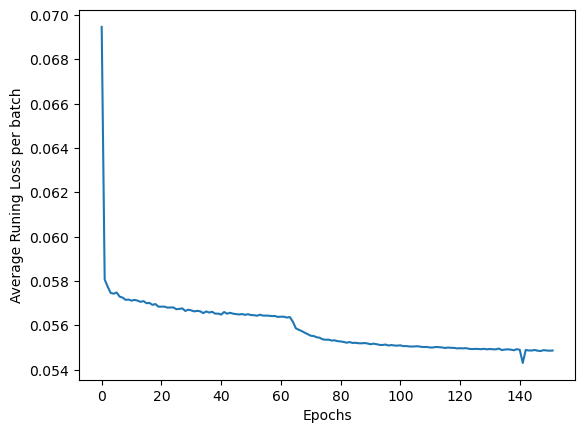

In [35]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [36]:
torch.save(final_model, 'model_100206_13g_03.pt')